In [257]:
import json
import numpy as np
np.set_printoptions(precision = 4)
import pandas as pd
import matplotlib.pyplot as plt
from operator import add

#The following will be used for creating a predictive model

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

%matplotlib inline
%precision %.6f
%pylab inline
pylab.rcParams['figure.figsize'] = (7.5, 7.5)

from IPython.display import clear_output

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Part 1: Exploratory data analysis

In [20]:
#Here we load the data in the appropiate format to be grouped ...
df = pd.read_json('logins.json')
df.set_index(pd.to_datetime(df['login_time']), inplace=True)
df['login_time'] = 1
df.columns = ['Counts']
df.head()

,Counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [21]:
#... and here we group the dat by 15min interval. column 'Counts represent the number of logins for
# a specific interval
h = df.groupby(pd.Grouper(freq='15T')).sum()
h['smoothed_Counts'] = pd.rolling_mean(h['Counts'], 20,center=False).fillna(0)
h['Percent_Change'] = h.Counts.pct_change() 
h['Counts'] = h['Counts'].fillna(0)
h['Day of the Week'] = h.index.weekday_name
h.fillna(0)
h.head()

/Users/saverm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
/Users/saverm/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


,Counts,smoothed_Counts,Percent_Change,Day of the Week
login_time,,,,
1970-01-01 20:00:00,2,0.0,NaN,Thursday
1970-01-01 20:15:00,6,0.0,2.000000,Thursday
1970-01-01 20:30:00,9,0.0,0.500000,Thursday
1970-01-01 20:45:00,7,0.0,-0.222222,Thursday
1970-01-01 21:00:00,1,0.0,-0.857143,Thursday


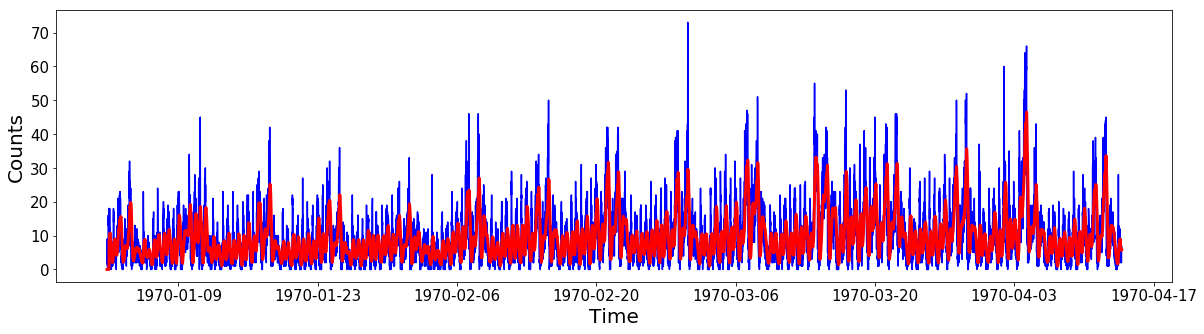

In [22]:
#Here we will plot Counts over time
fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(h.index.values,h.Counts.values, color = 'blue')
plt.plot(h.index.values,h.smoothed_Counts.values, color = 'red', linewidth =3)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Counts', fontsize = 20)
ax.tick_params(labelsize=15)
plt.show()

The plots suggest a periodicity in the count signal, perhaps weekly. We proceed to group the data by day of the week, and calculate the average  count.

In [23]:
d = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6,
    'Sunday': 7}
g = h.groupby('Day of the Week').mean()
g['DAY_OF_WEEK'] = g.index.tolist()
g['DAY_OF_WEEK'] = g['DAY_OF_WEEK'].apply(lambda x: d[x])

g.sort_values('DAY_OF_WEEK', inplace = True)
del g['Percent_Change']
del g['DAY_OF_WEEK']
g

,Counts,smoothed_Counts
Day of the Week,,
Monday,6.213380,6.250915
Tuesday,6.895833,6.638430
Wednesday,7.692708,7.492336
Thursday,8.794118,8.510735
Friday,10.561111,10.022118
Saturday,13.456250,13.925590
Sunday,12.615972,13.268958


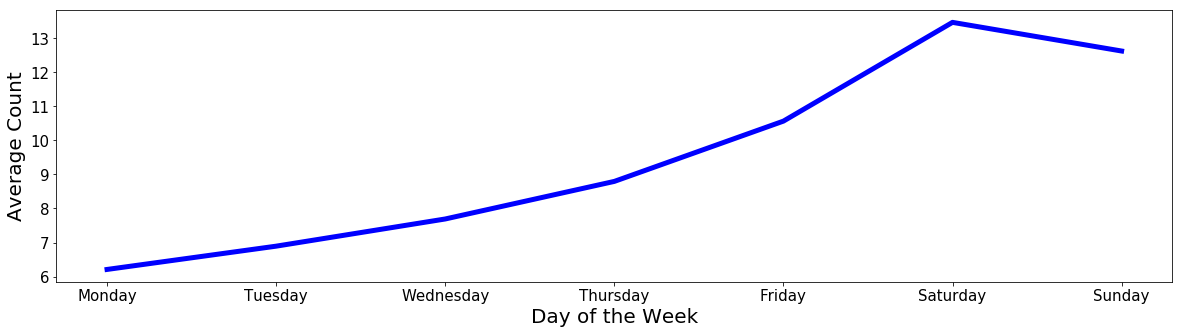

In [24]:
#Here we plot the number of counts by day of the week
fig, ax = plt.subplots(figsize = (20, 5))
plt.plot(g.index.values,g.Counts.values, color = 'blue', linewidth = 5)
plt.xlabel('Day of the Week', fontsize = 20)
plt.ylabel('Average Count', fontsize = 20)
ax.tick_params(labelsize=15)
plt.show()

As suspected, the average number of counts (logins) increases during the course a week, reaching a peak value on Saturday-Sunday.

# Part 2 ‑ Experiment and metrics design.

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1.- What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

A good measure could be the rate (e.g: number of drivers per hour) that travel from one city to another.
To make this measurements it might be best to  quantify  a period of time where there's considerable of activity in both cities. Taht is, during the weekends.

2.- Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment
We could assume that each driver would have on its vehicle a automatic detecter, like the ones that are used when a driver passes through a toll pass. One could implement this type of detection system at any  bridge of interest, and register each time a driver crosses from one city to another.
As explained before, we would restric this quantification to the weekend period

b. what statistical test(s) you will conduct to verify the significance of the observation.

We can quantify this by taking the proportion of trips to the neighboring city, out of the total number of trips executed. Then we would use a Z-test (http://www.statisticshowto.com/z-test/) to compare the two proportions.

To have a more representative measure, this proportions could be calculated by taking trips from a period of multiple weekends before and after the implementations of the toll reimbursement measure.


c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

If a significant increase in the proportion of trips executed to the oposite city, the measure would be considered a succes, otherwise the newly implemented policy needs to be revised.



# Part 3 - Prediction of rider retention

In [155]:
#Here we load the data in the appropiate format to be grouped ...
import json

with open('ultimate_data_challenge.json') as file:
    data =  json.load(file)
    
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [156]:
df['status'] = df['trips_in_first_30_days'].apply(lambda x: 'active' if x >= 1 else 'not-active')

print('Total number of active users: ' + str(np.sum(df.status == 'active')))
print('Total number of inactive users: ' + str(np.sum(df.status == 'not-active')))

Total number of active users: 34610
Total number of inactive users: 15390


In [157]:
#hEre we check for rows with NaN elements
df_s = df[np.sum(df.isnull(), axis = 1) > 0]
np.sum(df_s.isnull())

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
ultimate_black_user          0
weekday_pct                  0
status                       0
dtype: int64

This shows that there are missing values (NaN) only in 'avg_rating_by_driver', 'avg_rating_of_driver' and 'phone'.


In [158]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace = True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace = True)
df['phone'].fillna(df['phone'].value_counts().index[0], inplace = True)

In [159]:
#This woul confirm that the number of columns with NaN entries is 0.
df_s = df[np.sum(df.isnull(), axis = 1) > 0]
np.sum(df_s.isnull())

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
ultimate_black_user       0
weekday_pct               0
status                    0
dtype: int64

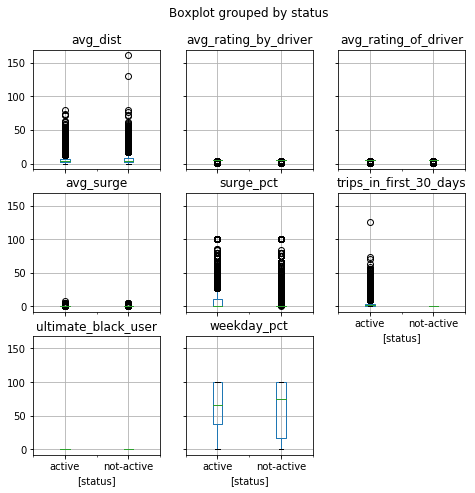

In [160]:
df.boxplot(by = 'status')
plt.show()

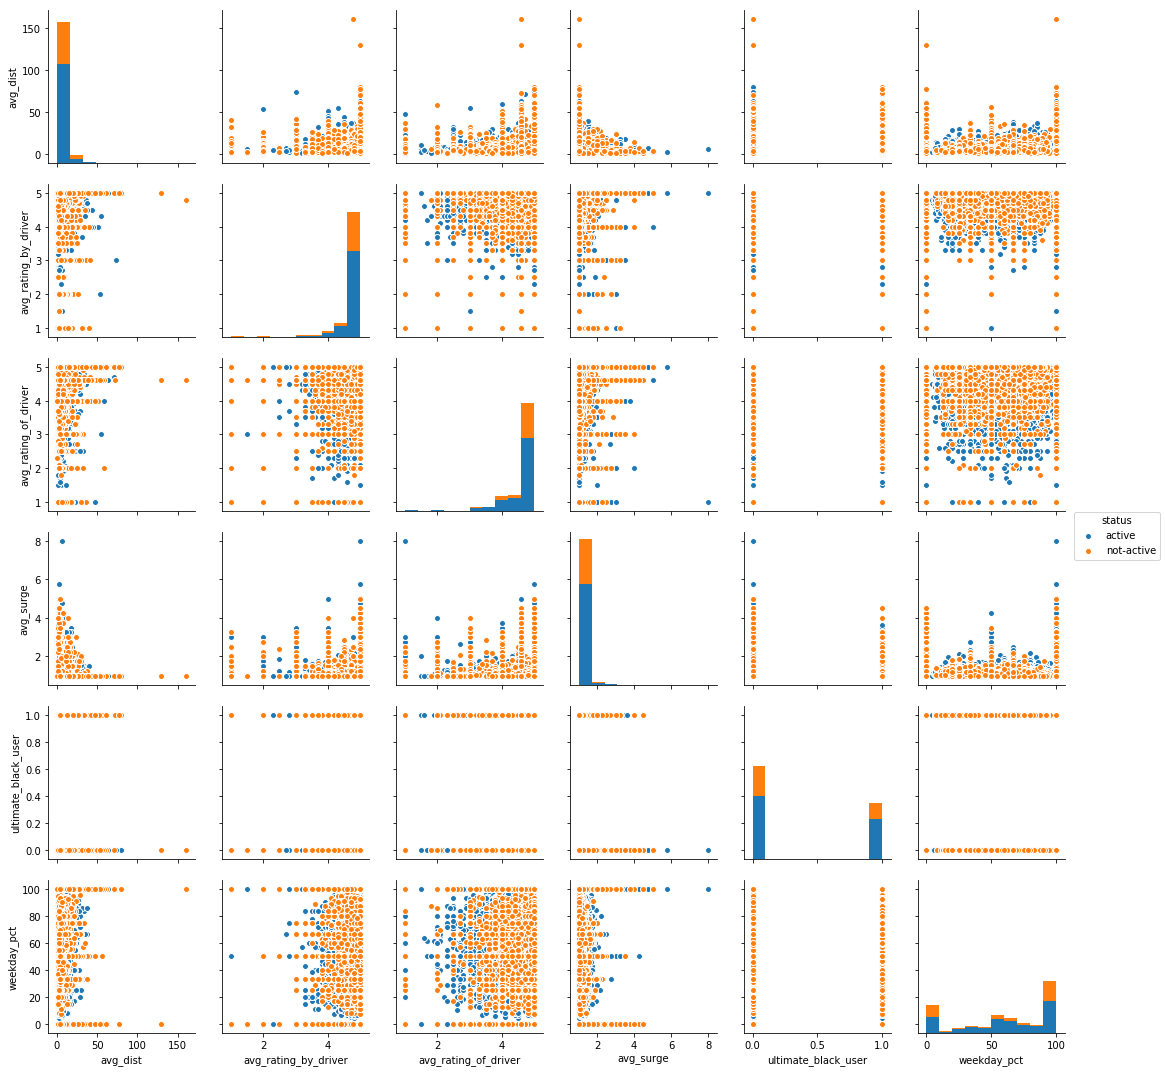

In [161]:
import seaborn as sns
columns = ['avg_dist','avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
           'ultimate_black_user', 'weekday_pct', 'status']
sns.pairplot(df[columns], hue = 'status')

In [32]:
from scipy import stats

columns = ['avg_dist','avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
           'ultimate_black_user', 'weekday_pct']

def is_significant(column):
    a = df[df['status'] == 'not-active'][column]
    b = df[df['status'] == 'active'][column]
    pval = stats.ttest_ind(a, b).pvalue
    if pval < 0.05:
        sig = 'Yes'
    else:
        sig = 'No'
    
    print('Is '+str(column) + ' significant?: ' + sig +';'), ('pvalue = '+str(pval))
    
for col in columns:
    is_significant(col)

Is avg_dist significant?: Yes; pvalue = 1.0779678630353311e-55
Is avg_rating_by_driver significant?: Yes; pvalue = 1.4482541883237358e-05
Is avg_rating_of_driver significant?: Yes; pvalue = 4.914244491830532e-10
Is avg_surge significant?: Yes; pvalue = 0.020922892160045396
Is ultimate_black_user significant?: Yes; pvalue = 2.172129229251902e-17
Is weekday_pct significant?: No; pvalue = 0.1333711507019858


The only numerical variable that is not significantly different between  active and not-active users is weekday-pct

In [33]:
categorical = ['city', 'phone', 'ultimate_black_user']
df_n = df[df['status'] == 'not-active']
df_a = df[df['status'] == 'active']

def plot_group(col):
    a = df_n[col].value_counts()
    b = df_a[col].value_counts()
    values = a.index.values
    a1 = []
    b1 = []
    for value in values:
        a1.append(a[value])
        b1.append(b[value])
        
    total = map(add, a1, b1)
    p_n = np.asarray(a1).astype('float')/np.asarray(total).astype('float')
    p_a = np.asarray(b1).astype('float')/np.asarray(total).astype('float')
    
    ind = np.arange(len(values))
    width = 0.5       
    
    p1 = plt.bar(ind, p_n, width)
    p2 = plt.bar(ind, p_a, width, bottom = p_n)
    plt.ylabel('proportions')
    plt.xticks(ind, values)
    plt.legend((p1[0], p2[0]), ('Not-Active', 'Active'), bbox_to_anchor=(1, 0.5))
    
    plt.show()

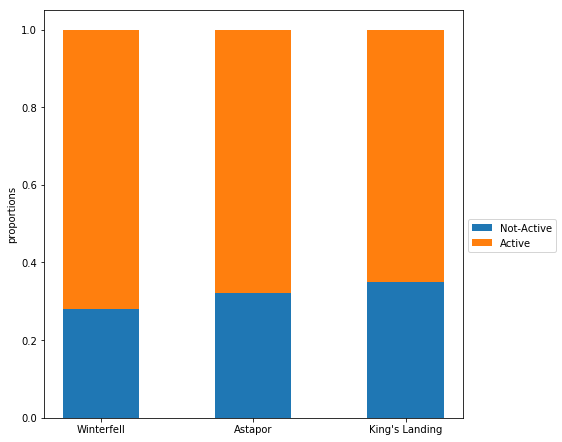

In [34]:
#plot proportion of active and non-active users by city
plot_group('city')

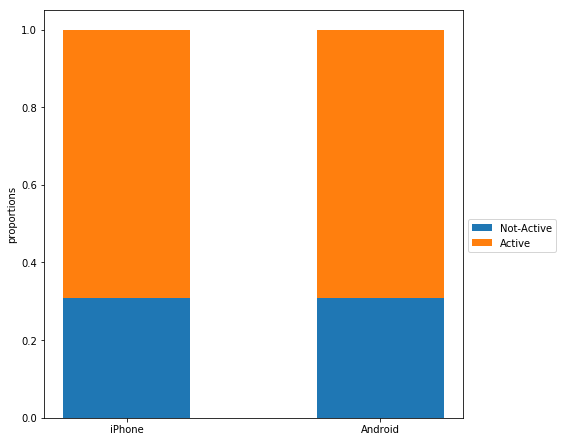

In [35]:
plot_group('phone')

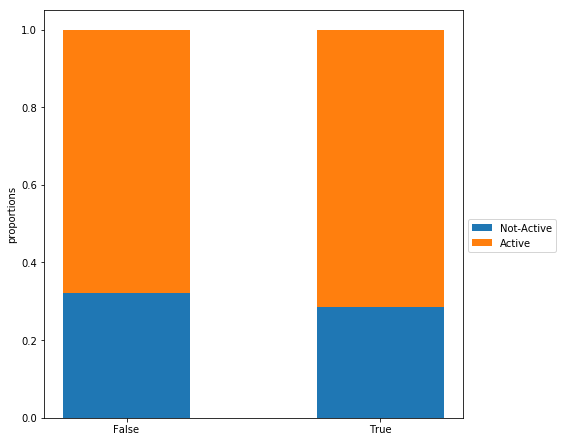

In [36]:
plot_group('ultimate_black_user')

From the previous plots the proportion of active/not-active users seems different onyl for 'city' and 'ultimate_black_user' but not for phone

Thus the variables that can be used in a predictive model are:

numerical = ['avg_dist','avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'ultimate_black_user']

categorical = categorical = ['city','ultimate_black_user']


# Building a predictive model 

In [216]:
df.city.value_counts().index.values

array([u'Winterfell', u'Astapor', u"King's Landing"], dtype=object)

In [252]:
numerical = ['avg_dist','avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',]
categorical = ['city','ultimate_black_user']

data_X = df[numerical + categorical]
data_Y = df['status'].apply(lambda x: 1 if x == 'active' else 0)

#First we need to convert the two categorical variables into numerical, 
# so that they can be used in a predictive model

le = preprocessing.LabelEncoder()
le_1 = preprocessing.LabelEncoder()

le.fit([u'Winterfell', u'Astapor', u"King's Landing"])
le_1.fit([True,False])

data_X['city'] = le.transform(df.city)
data_X['ultimate_black_user'] = le_1.transform(df.ultimate_black_user)

#We also normalize the columns to fit from 0 to 1 scale.
min_max_scaler = preprocessing.MinMaxScaler()

def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(min_max_scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])
    return df

data_X_norm = scaleColumns(data_X, data_X.columns.tolist())
data_X_norm.head()

/Users/saverm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/saverm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/saverm/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,ultimate_black_user
0,0.022801,1.000,0.925,0.014286,0.5,1.0
1,0.051317,1.000,1.000,0.000000,0.0,0.0
2,0.004784,1.000,0.825,0.000000,0.0,0.0
3,0.014662,0.975,0.900,0.020000,0.5,1.0
4,0.019446,0.975,0.850,0.027143,1.0,0.0


In [266]:
#Now, we create a train test split of the data
validation_size = .3
seed = 42
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data_X_norm,
                                                                    data_Y,
                                                                    test_size = validation_size,
                                                                    random_state=seed)

In [267]:
data_X_norm.shape

(50000, 6)

In [258]:
#Now we test multiple predictive models
seed = 7
scoring = 'accuracy'

# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('GNB', GaussianNB()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = model_selection.KFold(n_splits = 10, random_state = seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train,
                                                 cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.692971 (0.005400)
KNN: 0.649886 (0.007957)
CART: 0.599429 (0.007035)
RF: 0.626771 (0.004985)
GNB: 0.678571 (0.005354)


In [243]:
#The score is obtained for logistic regression, so
# we'll continue using LR for the generating a predictive model

param_grid = {'C': [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6] }
clf = GridSearchCV(LogisticRegression(penalty='l1'),
                   param_grid = param_grid, 
                   scoring = 'accuracy',
                   cv = 10)

clf.fit(X_train,Y_train)
clf.best_params_

{'C': 0.010000}

In [268]:
best_clf = LogisticRegression(C = 0.051795, penalty = 'l1')

best_clf.fit(X_train,Y_train)

LogisticRegression(C=0.051795, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [270]:
#Accuracy on train set
y_pred = best_clf.predict(X_train)
accuracy_score(Y_train, y_pred)

0.693486

In [271]:
#Accuracy on train set
y_pred = best_clf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.689333

In [178]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

predicted = best_clf.predict(X_test)

pd.crosstab(Y_test, predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,10,4652,4662
1,16,10322,10338
All,26,14974,15000


The diagonal of the confusion matrix(dataframe), represents the total number correct predcitions, in this case, a total of 10332 labels present on the test set.

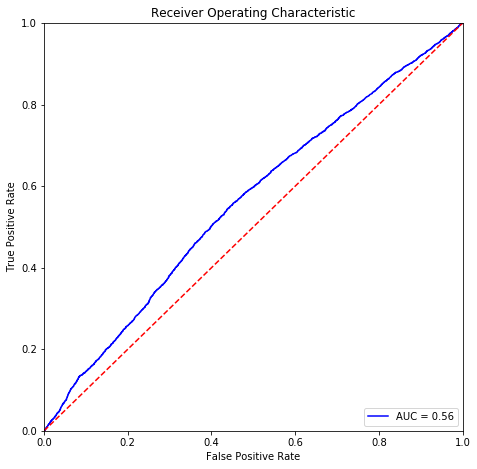

In [180]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [272]:
from sklearn.feature_selection import RFE
model = LogisticRegression(C = 0.1,penalty = 'l1')
# create the RFE model and select 3 attributes
rfe = RFE(model, 2)
rfe.fit(X_train,Y_train)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
print(data_X_norm.columns.tolist())

[ True False False False  True False]
[1 5 3 4 1 2]
[u'avg_dist', u'avg_rating_by_driver', u'avg_rating_of_driver', u'avg_surge', u'city', u'ultimate_black_user']


RFE (Rank feature selection) allows to create predictive models excluding 1 feature at a time, and the selecting the most important features (marked 'True' by  using rfe.support_). In the most improtant 2 features are:
[u'avg_dist', u'city']

In [273]:
data_X_norm_s = data_X_norm[[u'avg_dist', u'city']]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data_X_norm_s,
                                                                    data_Y,
                                                                    test_size = validation_size,
                                                                    random_state=seed)

data_X_norm_s.head()

,avg_dist,city
0,0.022801,0.5
1,0.051317,0.0
2,0.004784,0.0
3,0.014662,0.5
4,0.019446,1.0


In [274]:
#new model
model_2 = LogisticRegression(C = 0.1, penalty = 'l1')
model_2.fit(X_train,Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [277]:
#Accuracy on train set
y_pred = model_2.predict(X_train)
accuracy_score(Y_train, y_pred)

0.693429

In [279]:
#Accuracy on train set
y_pred = model_2.predict(X_test)
accuracy_score(Y_test, y_pred)

0.689133

In [280]:
probs = model_2.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

predicted = model_2.predict(X_test)

pd.crosstab(Y_test, predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,8,4654,4662
1,9,10329,10338
All,17,14983,15000


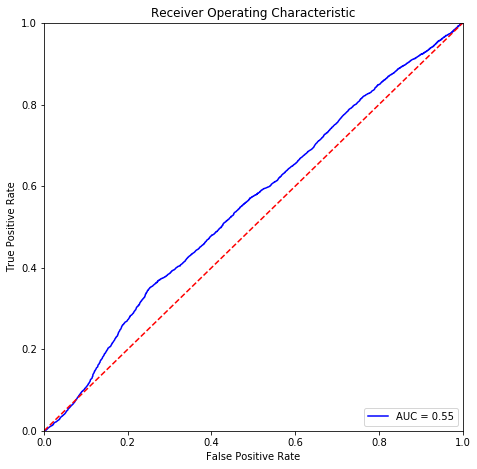

In [281]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

The logistic regression model presented here has an accuracy of ~ 70% of correctly predicting the activity status of costumers. While ,most of the features in the dataset were significantly different in between 'not-active' and 'active users', the differences were relatively small and with high dispersion (variability), which could explain why a higher accuracy was not obtained. Of note, the same level of accuracy could be achieved by using only two features.

My recomendation would be to investigate further to obtain/engineer new features that might improve the model's accuracy. Further analysis is necessary to establish wether the accuracy level of this model is adecuate for the requierements of Ultimate inc.